# <font color = 'blue'>  **Assignment 2: CIFAR-10 Color Channel Prediction** </font>

## Overview
Synesthesia is a neurological phenomenon where stimulation of one sensory pathway leads to involuntary experiences in a second sensory pathway—for example, seeing colors when hearing sounds. In this assignment, you'll work with the CIFAR-10 dataset to build a neural network that predicts one color channel of an image given the other two channels (for example, predicting blue from red and green), potentially simulating how synesthetic brains might infer missing sensory information from available inputs.

## Learning Objectives
- Understand the structure and properties of the CIFAR-10 dataset
- Learn about color channels and their relationships in RGB images
- Implement and train a convolutional neural network for regression
- Evaluate model performance using appropriate metrics
- Explore the relationship between different color channels in natural images

## Dataset
CIFAR-10 consists of 60,000 32×32 color images in 10 classes, with 6,000 images per class. Each image has three color channels (RGB) with pixel values ranging from 0-255. You'll use two channels as input features and one channel as your target variable.

### <font color = 'blue'> **Part 1: Data Exploration and Preprocessing (25 points)** </font>
1. Load the CIFAR-10 dataset and examine its structure
2. Visualize several sample images showing all three channels separately
3. Normalize the data appropriately for neural network training
4. Split the data into training, validation, and test sets
5. Create dataloaders

### <font color = 'blue'>  **Part 2: Model Design and Implementation (35 points)** </font>
Design a convolutional neural network that:
1. Takes two-channel input (choose any two color channels)
2. Outputs a single channel (the remaining color channel)
3. Uses appropriate activation functions for regression
4. Includes at least 3 convolutional layers
5. Incorporates techniques like batch normalization or dropout if beneficial

Implement your model using PyTorch.

### <font color = 'blue'>  **Part 3: Training and Optimization (25 points)** </font>
1. Choose an appropriate loss function for this regression task
2. Select an optimizer and learning rate schedule
3. Train your model while monitoring both training and validation loss
4. Implement early stopping to prevent overfitting
5. Experiment with different hyperparameters and document their effects

### <font color = 'blue'> **Part 4: Evaluation and Analysis (15 points)** </font>
1. Evaluate your model using metrics such as:
   - Mean Squared Error (MSE)
   - Mean Absolute Error (MAE)
   - Peak Signal-to-Noise Ratio (PSNR)
   - Structural Similarity Index (SSIM)
2. Visualize the images with the synthetic predicted channel
3. Analyze which types of images or regions your model handles well/poorly
4. Discuss the limitations of predicting one color channel from the other two

## Deliverables
Submit a Jupyter notebook that serves as both code and report, containing:
- Well-commented code for all parts
- Visualizations and analysis
- Markdown cells discussing your approach, findings, and insights throughout
- Your best trained model weights

## Bonus Opportunity
Try predicting each different third channel (predict red from green/blue, predict green from red/blue, predict blue from red/green) and analyze which color channel can be predicted most accurately from the other two.

**Submission Format**: Upload Jupyter notebook to Canvas.

This assignment bridges computer vision, color theory, and deep learning while providing hands-on experience with a well-known dataset in a novel context.

# Solution

References used :
1) CIFAR 10 - [link](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
2) Pytorch Documentation for Training a classifier - [link](https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

#### PART 1 - Predicting blue channel

In [116]:
import torch
import torchvision

In [5]:
trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testDataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print('Number of images in train set : ', len(trainDataset))
print('Number of images in test set : ', len(testDataset))


Number of images in train set :  50000
Number of images in test set :  10000


In [ ]:
trainDataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

In [18]:
print(trainDataset[49999])
print(trainDataset[0])

(<PIL.Image.Image image mode=RGB size=32x32 at 0x1353EDB20>, 1)
(<PIL.Image.Image image mode=RGB size=32x32 at 0x1352827B0>, 6)


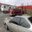

In [22]:
trainDataset[49999][0]

In [23]:
print(trainDataset[49999][1])

1


In [25]:
trainDataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

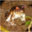

In [28]:
img, label = trainDataset[0]
img

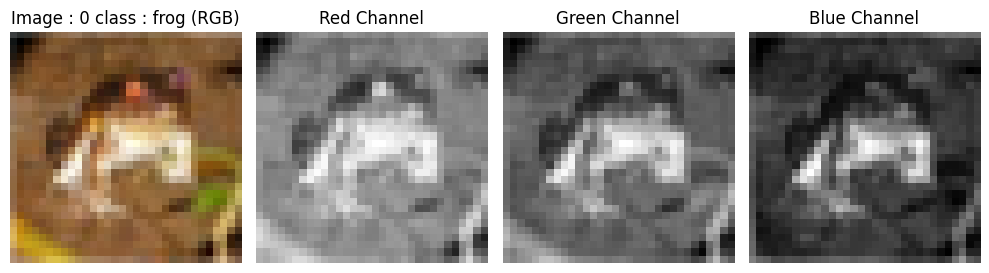

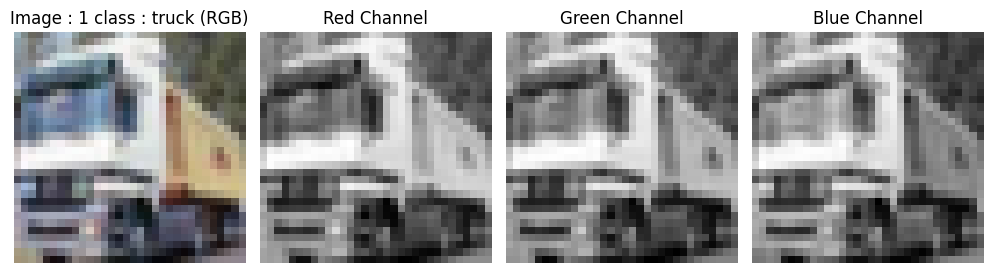

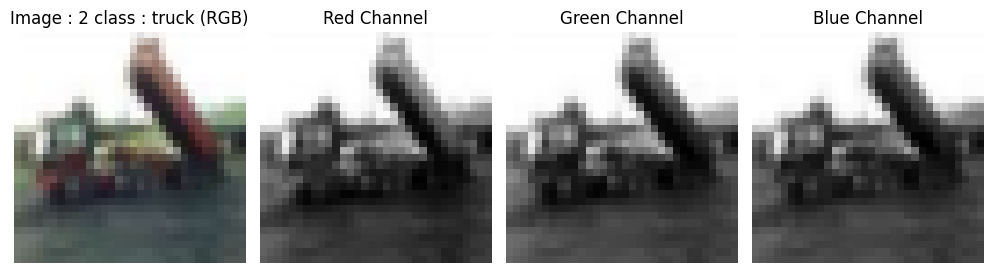

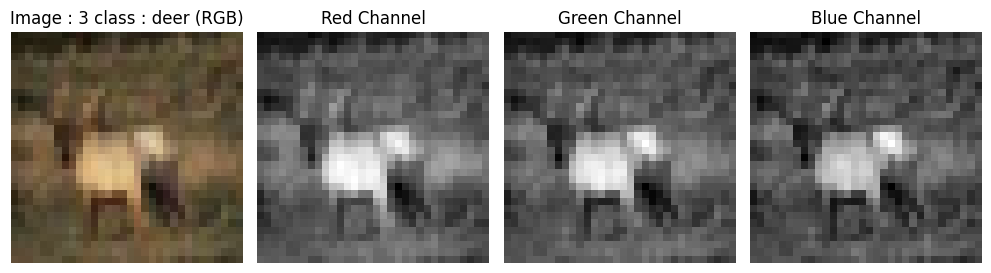

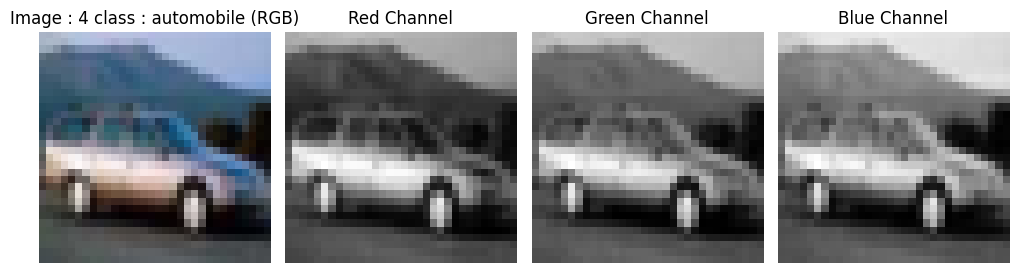

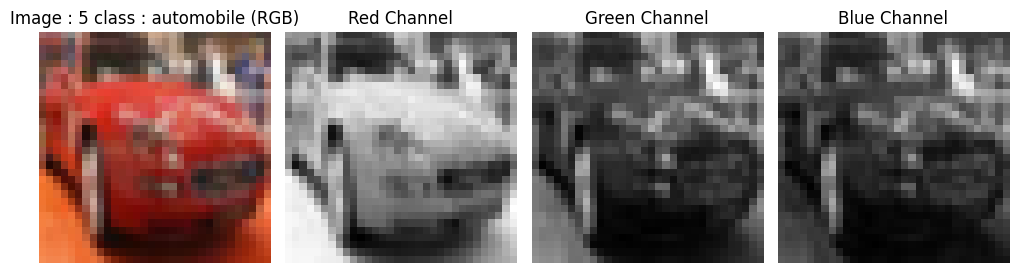

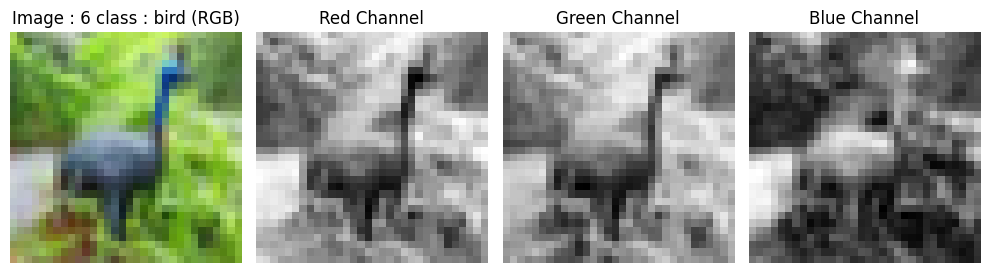

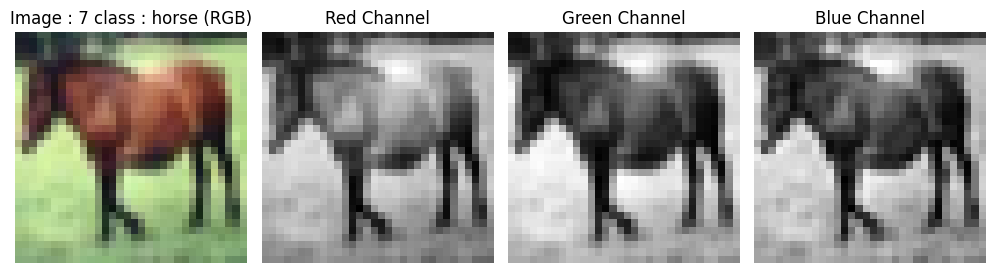

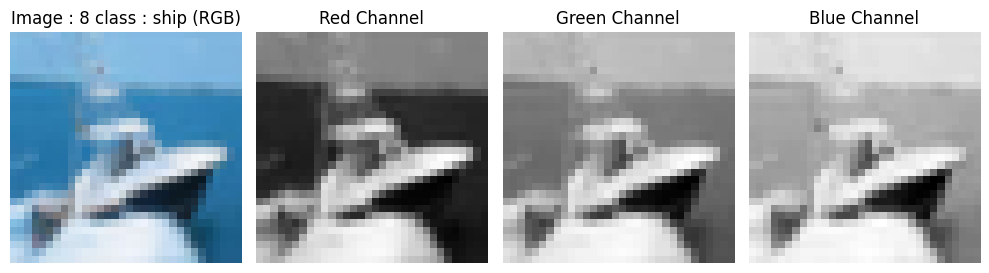

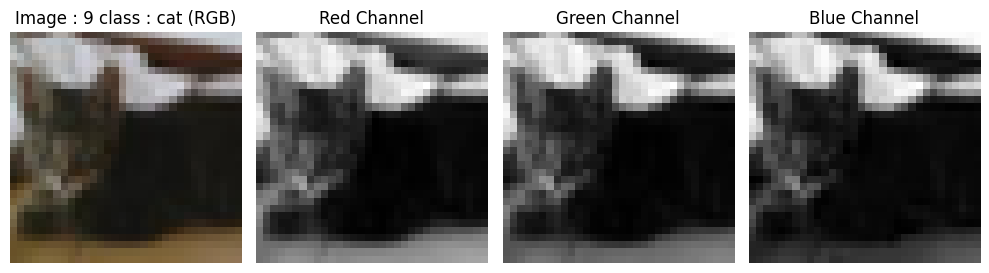

In [ ]:
import matplotlib.pyplot as plt

def showImageAndChannels(img, title):
    _ , axes = plt.subplots(1, 4, figsize=(10, 3))
    
    # the main image
    axes[0].imshow(img)
    axes[0].set_title(f"{title} (RGB)")
    axes[0].axis('off')    

    # its channels
    channels = ['Red', 'Green', 'Blue']
    r, g, b = img.split() #helps us get individual channels from a PIL image.
    channelImg = [r, g, b]
    for i in range(3):
        axes[i+1].imshow(channelImg[i], cmap='gray')
        axes[i+1].set_title(f"{channels[i]} Channel")
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()


for i in range(10):
    img, label = trainDataset[i]
    className = trainDataset.classes[label]
    showImageAndChannels(img,f"Image : {i} class : {className}")

The quality of these images isn't great given that it is of low resolution (32x32). Different channels have variations in their greyscale images in terms of their intensity. To learn the border pixels of cat, automobile and truck, padding should be considered.

For neural network training and normalization, let's reload the dataset.

In [ ]:
from torchvision import transforms

# first, we get tensors to calculate the mean and std dev across all images for each channel
toTensor = transforms.ToTensor()

trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=toTensor)
testDataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=toTensor)

In [90]:
trainDataset[0][0].shape

torch.Size([3, 32, 32])

In [91]:
def channelStats(dataset):
    imgs = torch.stack([img for img, _ in dataset]) # shape of imgs is [50k, 3, 32, 32] for trainDataset
    mean = imgs.mean(dim=[0, 2, 3])  # Mean over batch, height, width
    std = imgs.std(dim=[0, 2, 3])    # Std over batch, height, width
    return mean, std

mean, std = channelStats(trainDataset)
print(f"Channel means: {mean}")
print(f"Channel stds: {std}")

Channel means: tensor([0.4914, 0.4822, 0.4465])
Channel stds: tensor([0.2470, 0.2435, 0.2616])


Now, let's club them and get our dataset ready for NN processing. I could've done it by simply using imgs from torch.stack.

In [ ]:
transforms = transforms.Compose([
    toTensor,
    transforms.Normalize(mean,std)
])

trainDataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
testDataset = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transforms)

Splitting into train and val. We already have the test dataset.

In [93]:
from torch.utils.data.dataset import random_split

trainData, valData = random_split(trainDataset, [40000,10000]) # 80%, 20% respectively

Creating a custom dataset class to extract channels from images.

In [ ]:
from torch.utils.data import Dataset, DataLoader


class ChannelDataset(Dataset):
    def __init__(self, dataset, inputChannels = (0,1), outputChannel=2):
        self.dataset = dataset
        self.inputChannels = inputChannels  # r and g
        self.outputChannel = outputChannel  # blue
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        img, _ = self.dataset[index] #ignoring label since we don't need it
        inputImg = img[self.inputChannels,:,:]
        outputImg = img[self.outputChannel,:,:].unsqueeze(0) # reshape the tensor
        return inputImg, outputImg
        

train = ChannelDataset(trainData, inputChannels=(0,1), outputChannel=2)
val = ChannelDataset(valData,inputChannels=(0,1), outputChannel=2)
test = ChannelDataset(testDataset,inputChannels=(0,1), outputChannel=2)  

# Testing it out
batchSize = 16
trainLoader = DataLoader(train, batchSize, shuffle=True)
valLoader = DataLoader(val,batchSize,shuffle=True)

for xt, yt in trainLoader:
    print('Shape of input ', xt.shape)
    print('Shape of output ', yt.shape)
    break

Shape of input  torch.Size([16, 2, 32, 32])
Shape of output  torch.Size([16, 1, 32, 32])


### PART 2 : Designing the architecture 

In [119]:
import torch.nn as nn

In [221]:
class ColorChannelPredictor(nn.Module):
    def __init__(self, dropoutProbability = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=4, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(4)
        self.conv6 = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, padding=1)
        self.dropout = nn.Dropout2d(p=dropoutProbability)
    
    def forward(self,x):
        x = self.conv1(x)           # (Batch, 2, 32, 32) -> (Batch, 4, 32, 32)
        x = self.relu(self.bn1(x))  
        x = self.conv2(x)           # (Batch, 4, 32, 32) -> (Batch, 16, 32, 32)
        x = self.relu(self.bn2(x))
        x = self.conv3(x)           # (Batch, 16, 32, 32) -> (Batch, 32, 32, 32)
        x = self.relu(self.bn3(x))
        x = self.dropout(x)
        x = self.conv4(x)           # (Batch, 32, 32, 32) -> (Batch, 16, 32, 32)
        x = self.relu(self.bn4(x))
        x = self.conv5(x)           # (Batch, 16, 32, 32) -> (Batch, 4, 32, 32)
        x = self.relu(self.bn5(x))
        x = self.conv6(x)           # (Batch, 4, 32, 32) -> (Batch, 1, 32, 32)
        return x
        
model = ColorChannelPredictor()
print(model)

# Test model 
sample_input = torch.randn(1, 2, 32, 32) 
output = model(sample_input)
print(f"Output shape: {output.shape}")
print(output)

ColorChannelPredictor(
  (conv1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
)
Output shape: 

### Part 3 - Tuning

Set the model to run on GPU

In [222]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Using MPS (Apple GPU)')

Using MPS (Apple GPU)


Considering mean squared error loss, stochastic gradient descent optimizer while reducing the learning rate when the validation loss plateaus.

In [225]:
import torch.optim as optim
import copy
import itertools

def training(dropout,learningRate,batchSize, train, val):
    
    print('------------------------------------------------')
    print('------------------------------------------------')
    print(f'Hyperparameters are \n Dropout = {dropout}, Batch Size  = {batchSize} and Learning Rate = {learningRate}')
    print('------------------------------------------------')
    model = ColorChannelPredictor(dropoutProbability=dropout)
    model.to(device) #move the model to gpu
    trainLoader = DataLoader(train, batchSize, shuffle=True)
    valLoader = DataLoader(val,batchSize,shuffle=True)
    loss = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(),lr=learningRate)
    reduceLRonPlat = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    def makeTrainStep(model,lossFunction,optimizer):
        def trainStep(x,y):
            model.train()
            pred = model(x)
            loss = lossFunction(pred,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            return loss.item()
        return trainStep

    def makeValStep(model, lossFunction):
        def valStep(x,y):
            model.eval()
            pred = model(x)
            loss = lossFunction(pred,y)
            return loss.item()
        return valStep


    def forEpochs(epochs, trainLoader, valLoader,  trainStep, valStep, scheduler=None, earlyStopWindow=5):
        trainLosses = []
        valLosses = []
        bestValLoss = float('inf')
        bestWeights = copy.deepcopy(model.state_dict())
        epochsWithNoImprovement = 0
        for epoch in range(epochs):
            # train data
            trainLoss = 0.0 
            trainSamples = 0
            for xB, yB in trainLoader:
                x = xB.to(device)
                y = yB.to(device)
                loss = trainStep(x,y)
                #print('Train Loss is ', loss) #debugging
                batchSize = x.size(0)
                #print('Batch size is ', batchSize)
                trainLoss += loss * batchSize # loss is multiplied by batch size
                #print('Train Loss per sample is ',trainLoss)
                trainSamples += batchSize      
            avgTrainLoss = trainLoss / trainSamples # avg loss 
            #print('Avg train loss per sample is ', avgTrainLoss)
            trainLosses.append(avgTrainLoss) 
            
            # val data
            valLoss = 0.0
            valSamples = 0
            with torch.no_grad():
                for xB, yB in valLoader:
                    x = xB.to(device)
                    y = yB.to(device)
                    loss = valStep(x,y)
                    #print('Loss is ', loss) #debugging
                    batchSize = x.size(0)
                    #print('Batch size is ', batchSize)
                    valLoss += loss * batchSize 
                    #print('Val Loss per sample is ', valLoss)
                    valSamples += batchSize  
            avgValLoss = valLoss / valSamples   
            #print('Avg val loss per sample is ', avgTrainLoss) 
            valLosses.append(avgValLoss)
            
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avgTrainLoss:.6f}, Val Loss: {avgValLoss:.6f}")

            if scheduler:
                scheduler.step(avgValLoss)

            if avgValLoss < bestValLoss:
                bestValLoss = avgValLoss
                bestWeights = copy.deepcopy(model.state_dict())
                epochsWithNoImprovement = 0
            else:
                epochsWithNoImprovement += 1
                if epochsWithNoImprovement >= earlyStopWindow:
                    break

        return trainLosses, valLosses, bestWeights
    
    trainStep = makeTrainStep(model, loss, optimizer)
    valStep = makeValStep(model,loss)
    return forEpochs(50, trainLoader, valLoader, trainStep, valStep, scheduler=reduceLRonPlat)


def tuning(train,val,params):
    bestValLoss = float('inf')
    bestParams = None
    bestWeights = None
    bestTrainLossArray = []
    bestValLossArray = []
    results = []
    for d, l, b in itertools.product(params['dropoutValues'], params['lrValues'],params['batchSizeValues']): #helps me get the catersian product, giving all the possible combinations of my hyperparameters.
        trainLosses, valLosses, weights = training(d,l,b, train,val)
        leastValLoss = min(valLosses)
        results.append({'dropout':d, 'learningRate':l, 'batchSize':b, 'LeastValLoss': leastValLoss})
        if leastValLoss < bestValLoss:
            bestValLoss = leastValLoss
            bestParams = {'dropout':d, 'learningRate':l, 'batchSize':b}
            bestTrainLossArray = trainLosses
            bestValLossArray = valLosses
            bestWeights = weights
    return bestParams, bestWeights, bestTrainLossArray, bestValLossArray, results

params = {
    'dropoutValues' : [0.2, 0.3, 0.4, 0.5],
    'lrValues' : [1e-4, 1e-3, 1e-2, 1e-1],
    'batchSizeValues' : [16, 32, 64, 128]
}

bestParams, bestWeights, bestTrainLossArray, bestValLossArray, results = tuning(train,val,params)

------------------------------------------------
------------------------------------------------
Hyperparameters are 
 Dropout = 0.2, Batch Size  = 16 and Learning Rate = 0.0001
------------------------------------------------
Epoch 1/50, Train Loss: 0.581865, Val Loss: 0.348733
Epoch 2/50, Train Loss: 0.347861, Val Loss: 0.282295
Epoch 3/50, Train Loss: 0.304846, Val Loss: 0.254209
Epoch 4/50, Train Loss: 0.284892, Val Loss: 0.240362
Epoch 5/50, Train Loss: 0.271107, Val Loss: 0.230656
Epoch 6/50, Train Loss: 0.263062, Val Loss: 0.222772
Epoch 7/50, Train Loss: 0.255501, Val Loss: 0.218447
Epoch 8/50, Train Loss: 0.249793, Val Loss: 0.214768
Epoch 9/50, Train Loss: 0.245262, Val Loss: 0.209252
Epoch 10/50, Train Loss: 0.240337, Val Loss: 0.209736
Epoch 11/50, Train Loss: 0.238411, Val Loss: 0.203631
Epoch 12/50, Train Loss: 0.235319, Val Loss: 0.204009
Epoch 13/50, Train Loss: 0.233488, Val Loss: 0.203644
Epoch 14/50, Train Loss: 0.229794, Val Loss: 0.199501
Epoch 15/50, Train Loss: 

In [226]:
for res in results:
    print(res)

{'dropout': 0.2, 'learningRate': 0.0001, 'batchSize': 16, 'LeastValLoss': 0.17140913729667664}
{'dropout': 0.2, 'learningRate': 0.0001, 'batchSize': 32, 'LeastValLoss': 0.18052238273620605}
{'dropout': 0.2, 'learningRate': 0.0001, 'batchSize': 64, 'LeastValLoss': 0.1950607927799225}
{'dropout': 0.2, 'learningRate': 0.0001, 'batchSize': 128, 'LeastValLoss': 0.2260124547958374}
{'dropout': 0.2, 'learningRate': 0.001, 'batchSize': 16, 'LeastValLoss': 0.15080401701927185}
{'dropout': 0.2, 'learningRate': 0.001, 'batchSize': 32, 'LeastValLoss': 0.15654991018772124}
{'dropout': 0.2, 'learningRate': 0.001, 'batchSize': 64, 'LeastValLoss': 0.15696035993099214}
{'dropout': 0.2, 'learningRate': 0.001, 'batchSize': 128, 'LeastValLoss': 0.16793190253973006}
{'dropout': 0.2, 'learningRate': 0.01, 'batchSize': 16, 'LeastValLoss': 0.14584102935791016}
{'dropout': 0.2, 'learningRate': 0.01, 'batchSize': 32, 'LeastValLoss': 0.1494455882549286}
{'dropout': 0.2, 'learningRate': 0.01, 'batchSize': 64, 'Le

Plotting for the best model

In [227]:
import plotly.graph_objects as go

fig = go.Figure()
x = list(range(len(bestTrainLossArray)))  
fig.add_trace(go.Scatter(x=x,y=bestTrainLossArray, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=x,y=bestValLossArray, mode='lines', name='Validation Loss'))
fig.update_layout(
    title=f'Training and Validation Losses for {bestParams['dropout']} dropout, {bestParams['learningRate']} learning rate and {bestParams['batchSize']} batch size',
    xaxis_title='Epoch',
    yaxis_title='MSE Loss',
    legend_title='Legend'
)
fig.show()

* Validation losses are lower because of dropout.

Loading the best model for the next phase

In [228]:
bestModel = ColorChannelPredictor(dropoutProbability=bestParams['dropout'])
bestModel.load_state_dict(bestWeights)
bestModel.to(device)

ColorChannelPredictor(
  (conv1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
)

Saving it locally for convenience 

In [229]:
torch.save(bestModel.state_dict(), f"model_lr{bestParams['learningRate']}_drop{bestParams['dropout']}_bs{bestParams['batchSize']}.pth")

In [230]:
bestParams

{'dropout': 0.2, 'learningRate': 0.1, 'batchSize': 64}

### Part 4 - Evaluation and Analysis

In [231]:
print(mean)
print(std)
print(mean[2])
print(std[2])

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])
tensor(0.4465)
tensor(0.2616)


In [232]:
from pytorch_msssim import SSIM

testLoader = DataLoader(test, bestParams['batchSize'], shuffle=False)  # No shuffling for consistent eval

# Signal-to-Noise Ratio 
def computeSNR(original, predicted):
    signalPower = torch.mean(original**2)
    noisePower = torch.mean((predicted-original)**2)
    if noisePower == 0:
        return float('inf')
    snr = 10 * torch.log10(signalPower/noisePower)
    return snr.item()

def computeMetrics(model, testLoader):
    mse = nn.MSELoss()
    mae = nn.L1Loss()
    ssim = SSIM(data_range=1.0, channel=1)  # Data range [0,1] after denormalization
    
    mseScores = []
    maeScores = []
    snrScores = []
    ssimScores = []

    twoChannels = []
    singleChannel = []
    predictedSingleChannel = []

    totalSamples = 0
    totalMSE = 0.0
    totalMAE = 0.0
    totalSNR = 0.0
    totalSSIM = 0.0

    with torch.no_grad():
        for xb, yb in testLoader:
            batchSize = xb.size(0)
            totalSamples += batchSize

            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)

            # Compute MSE and MAE
            mseLoss = mse(pred, yb).item() * batchSize
            maeLoss = mae(pred, yb).item() * batchSize
            totalMSE += mseLoss
            totalMAE += maeLoss

            # Denormalize for SNR and SSIM
            denormalizedYb = yb * std[2] + mean[2]  # Blue channel: [0,1] range
            denormalizedPred = pred * std[2] + mean[2]

            # Compute SNR and SSIM
            snr = computeSNR(denormalizedYb, denormalizedPred)  # Per-batch SNR
            ssimScore = ssim(denormalizedYb, denormalizedPred).item()  # Per-batch SSIM

            # Accumulate totals for averaging
            totalSNR += snr * batchSize  # Weight by batch size
            totalSSIM += ssimScore * batchSize  # Weight by batch size

            # per-batch metrics
            mseScores.append(mseLoss / batchSize)  
            maeScores.append(maeLoss / batchSize)  
            snrScores.append(snr) 
            ssimScores.append(ssimScore)

            twoChannels.append(xb.cpu())
            singleChannel.append(yb.cpu())
            predictedSingleChannel.append(pred.cpu())

    # Avg metrics
    avgMse = totalMSE / totalSamples
    avgMae = totalMAE / totalSamples
    avgSNR = totalSNR / totalSamples
    avgSSIM = totalSSIM / totalSamples

    return avgMse, avgMae, avgSNR, avgSSIM, twoChannels, singleChannel, predictedSingleChannel

avgMse, avgMae, avgSNR, avgSSIM, twoChannels, singleChannel, predictedSingleChannel  = computeMetrics(bestModel,testLoader)

print(f"Test MSE for blue channel: {avgMse:.6f}")
print(f"Test MAE for blue channel: {avgMae:.6f}")
print(f"Test SNR for blue channel: {avgSNR:.6f} dB")
print(f"Test SSIM for blue channel: {avgSSIM:.6f}")

Test MSE for blue channel: 0.144929
Test MAE for blue channel: 0.257438
Test SNR for blue channel: 14.451837 dB
Test SSIM for blue channel: 0.872056


* There are moderate errors.
* SNR suggests that there is a lot of noise in the predicted images. 
* SSIM value is great, suggesting that the model preserves structural and perceptual details.

In [233]:
testDataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Best 10 images (lowest MSE):
MSE: 0.001737, Batch: 13, Image: 25


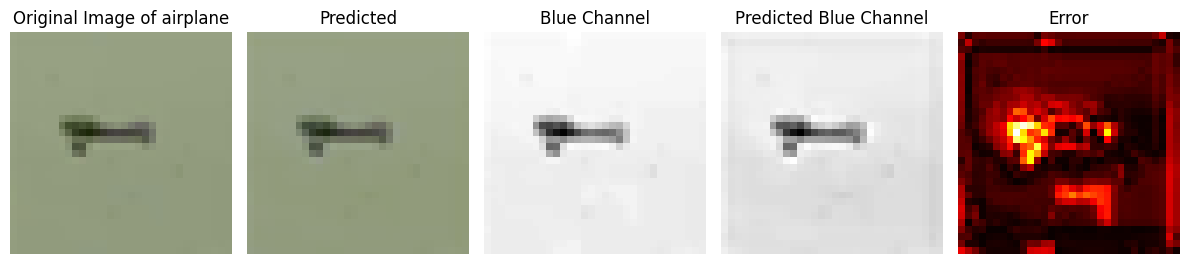

MSE: 0.003008, Batch: 90, Image: 46


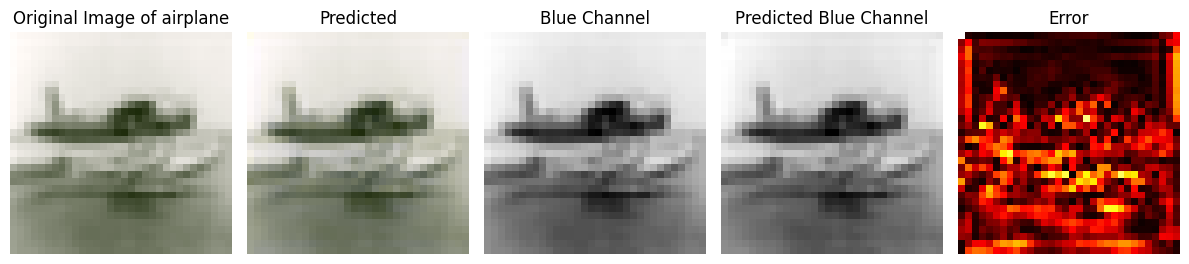

MSE: 0.003243, Batch: 7, Image: 51


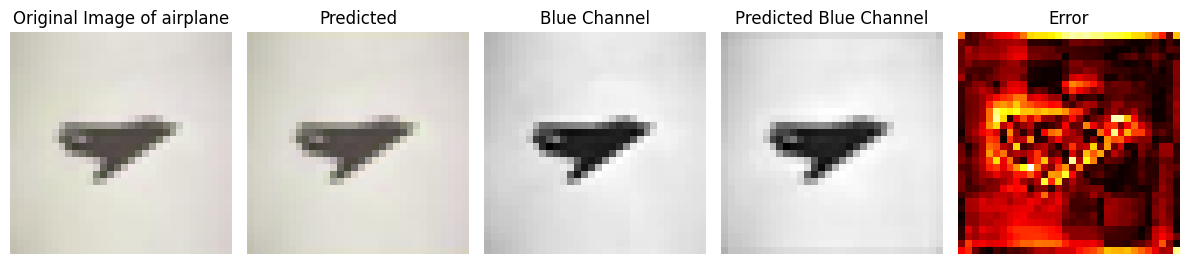

MSE: 0.003363, Batch: 135, Image: 56


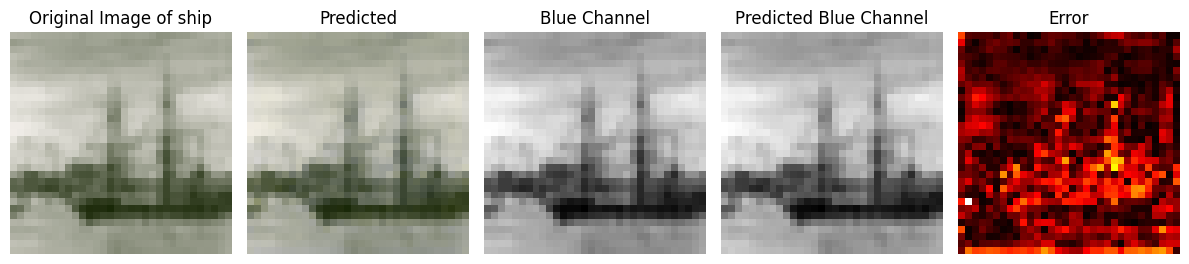

MSE: 0.003631, Batch: 144, Image: 19


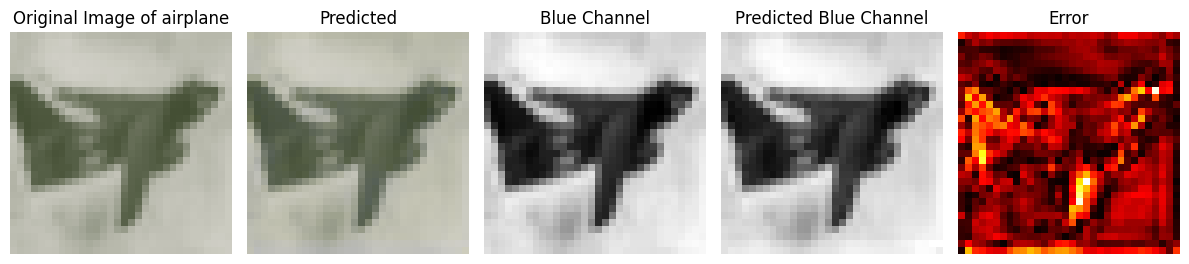

MSE: 0.003632, Batch: 26, Image: 0


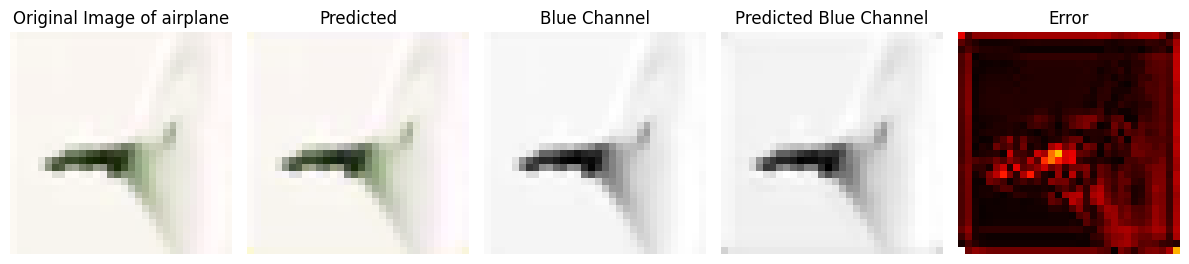

MSE: 0.003733, Batch: 47, Image: 15


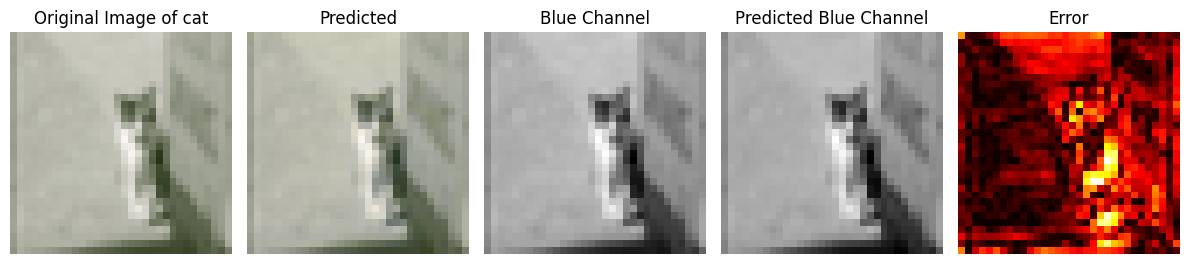

MSE: 0.003748, Batch: 27, Image: 59


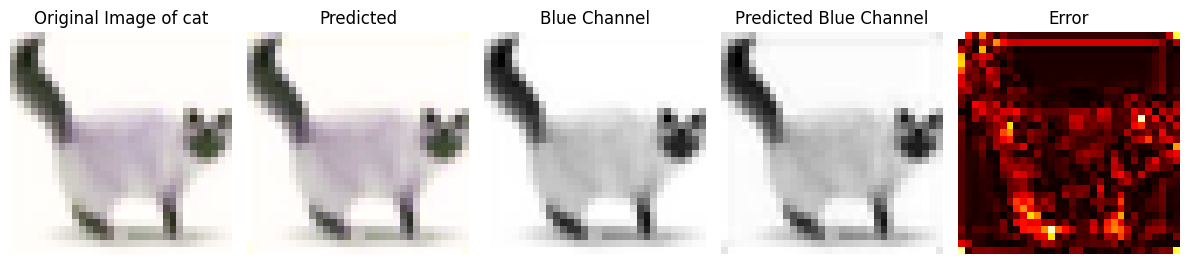

MSE: 0.003798, Batch: 9, Image: 9


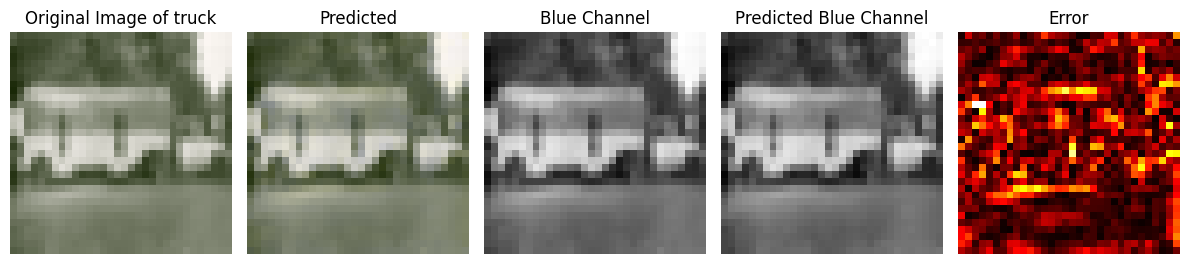

MSE: 0.004050, Batch: 54, Image: 13


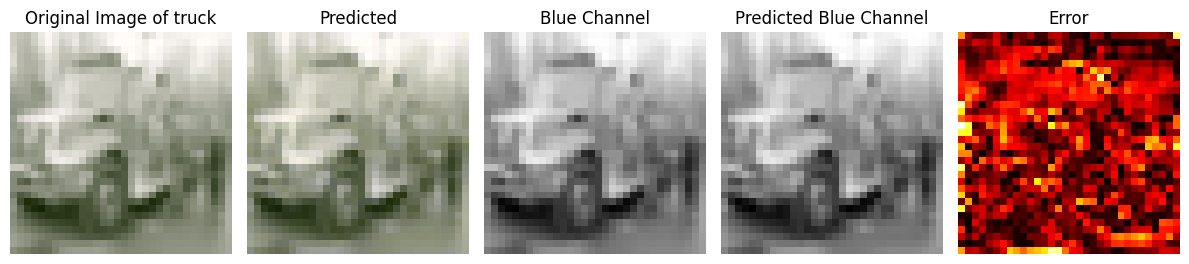

------------------------------------------------------------------------
Worst 10 images (highest MSE):
MSE: 2.848785, Batch: 15, Image: 59


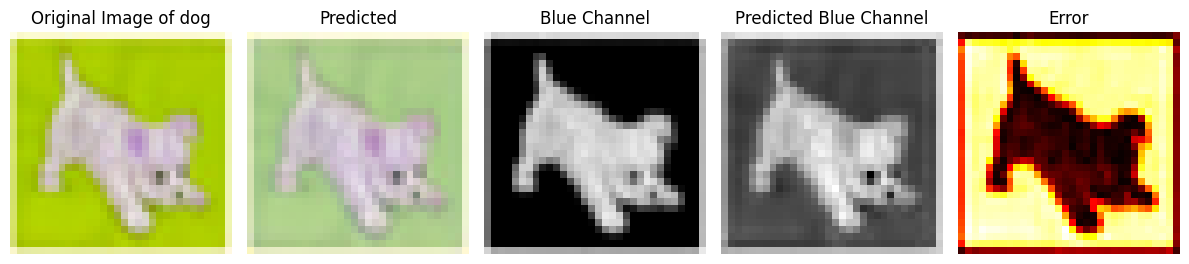

MSE: 2.907440, Batch: 63, Image: 28


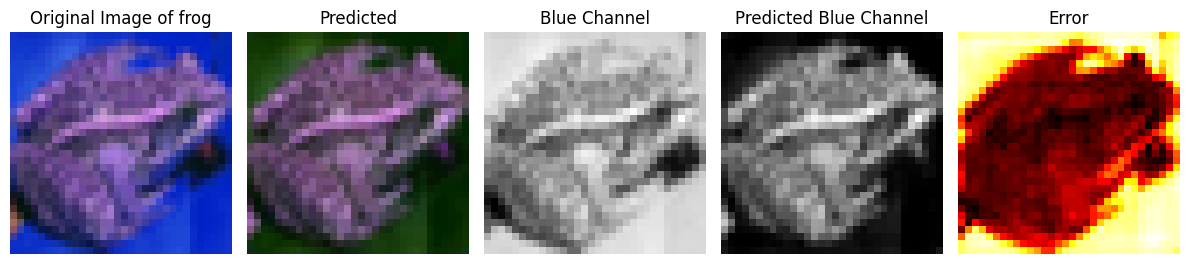

MSE: 2.941758, Batch: 90, Image: 14


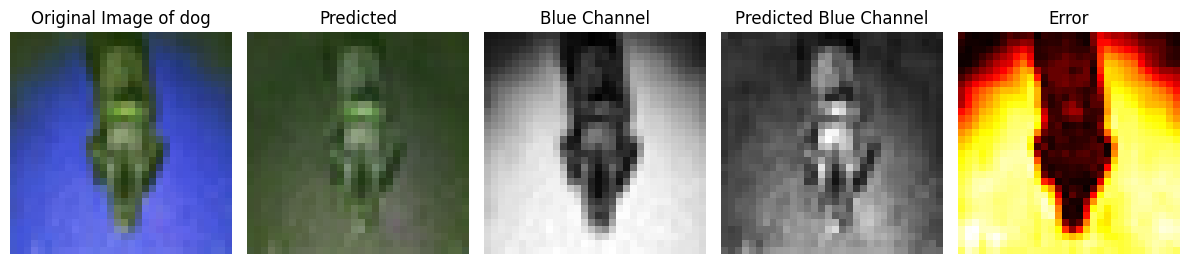

MSE: 2.956606, Batch: 114, Image: 63


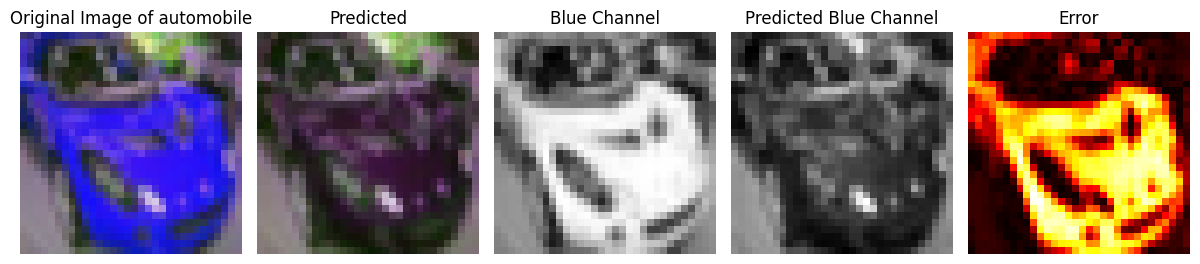

MSE: 3.140235, Batch: 116, Image: 20


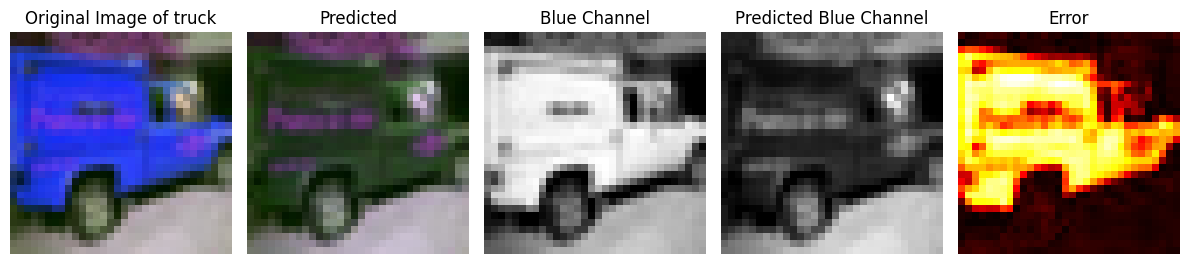

MSE: 3.206683, Batch: 151, Image: 1


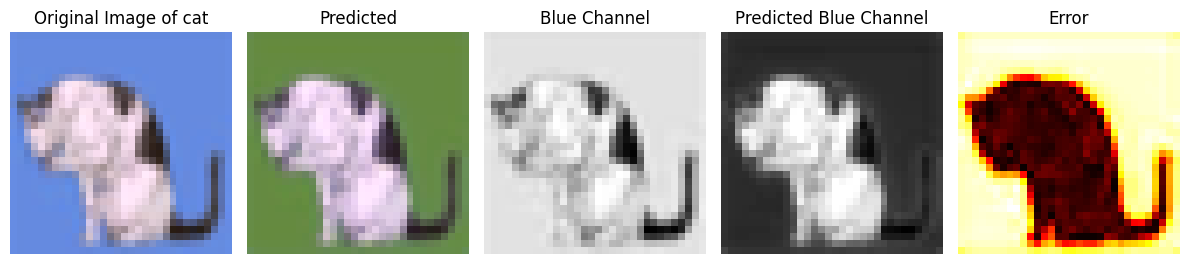

MSE: 3.411177, Batch: 132, Image: 21


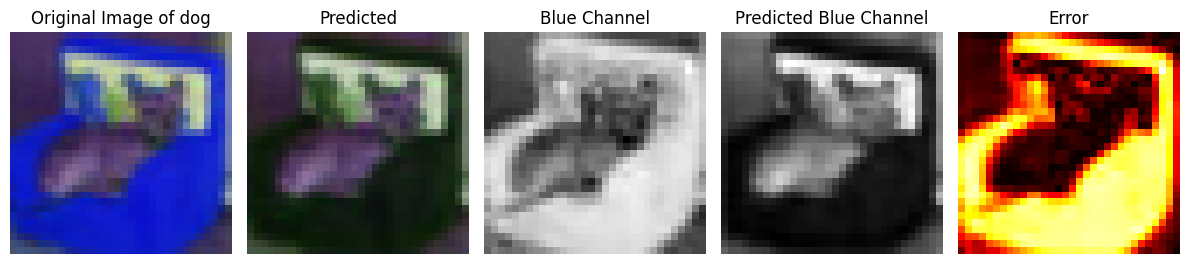

MSE: 3.784046, Batch: 50, Image: 21


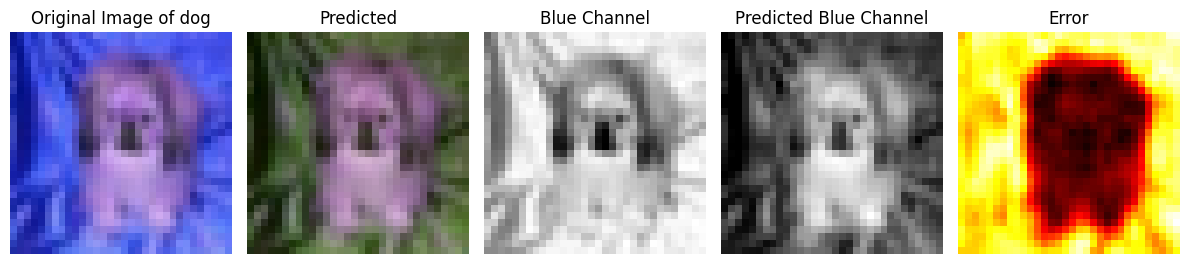

MSE: 3.879181, Batch: 69, Image: 26


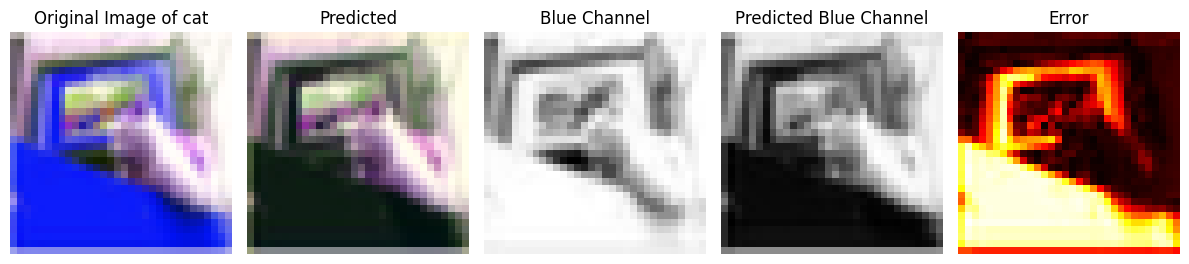

MSE: 5.477623, Batch: 69, Image: 37


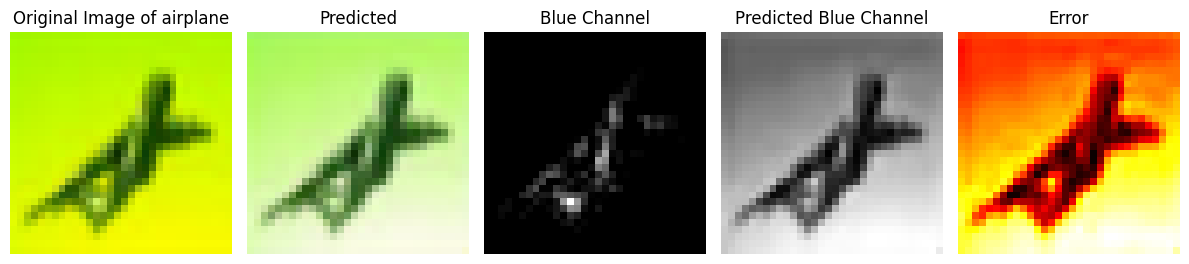

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def visualizeImages(x,y,pred,label):
    rgb = torch.zeros(3,32,32)          # initializing images
    rgbDistored = torch.zeros(3,32,32)
    
    # reconstructing the original img
    rgb[0:2,:,:] = x    
    rgb[2,:,:] = y

    # constructing the distorted img
    rgbDistored[0:2,:,:] = x
    rgbDistored[2:,:,:] = pred

    # denormalization of blue channel and predicted blue channel
    yDenorm = y * std[2] + mean[2]
    predDenorm = pred * std[2] + mean[2]

    # error map, converting to numpy to display the image and fixing its range between 0 and 1. Squeeze helps us drop the channel dimension.
    error = (yDenorm - predDenorm).abs().clamp(0,1).squeeze(0).numpy()

    # for blue channel
    yDenormImg = yDenorm.clamp(0,1).squeeze(0).numpy()

    # for predicted blue channel
    predDenormImg = predDenorm.clamp(0,1).squeeze(0).numpy()

    # denormalizingg the original and predicted images
    rgbDenorm = rgb * std.view(3,1,1) + mean.view(3,1,1)          # broadcasting
    rgbDistoredDenorm = rgbDistored * std.view(3,1,1) + mean.view(3,1,1)

    # ensuring they're suitable for imshow
    img = rgbDenorm.clamp(0,1).numpy().transpose(1,2,0)                     # reshaping C, H, W -> H, W, C
    distortedImg = rgbDistoredDenorm.clamp(0,1).numpy().transpose(1,2,0)
    
    _, axes = plt.subplots(1, 5, figsize=(12, 3))
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image of {testDataset.classes[label]}')
    axes[0].axis('off')

    axes[1].imshow(distortedImg)
    axes[1].set_title('Predicted')
    axes[1].axis('off')

    axes[2].imshow(yDenormImg, cmap='gray')
    axes[2].set_title('Blue Channel')
    axes[2].axis('off')

    axes[3].imshow(predDenormImg, cmap='gray')
    axes[3].set_title('Predicted Blue Channel')
    axes[3].axis('off')

    axes[4].imshow(error, cmap='hot') # gradient from black -> red -> yellow -> white, errors increase from black to white.
    axes[4].set_title('Error')
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()

# calculating MSE per image
msePerImage = []
for i in range(len(predictedSingleChannel)):
    for j in range(predictedSingleChannel[i].shape[0]):
        mse = mean_squared_error(predictedSingleChannel[i][j].flatten(), singleChannel[i][j].flatten())
        msePerImage.append((mse, i, j))
    
msePerImage.sort()

print("Best 10 images (lowest MSE):")
for mse, batchIndex, imgIndex in msePerImage[:10]:
    print(f"MSE: {mse:.6f}, Batch: {batchIndex}, Image: {imgIndex}")
    visualizeImages(twoChannels[batchIndex][imgIndex], singleChannel[batchIndex][imgIndex], predictedSingleChannel[batchIndex][imgIndex], testDataset[bestParams['batchSize']*batchIndex+imgIndex][1])
print("------------------------------------------------------------------------")
print("Worst 10 images (highest MSE):")
for mse, batchIndex, imgIndex in msePerImage[-10:]:
    print(f"MSE: {mse:.6f}, Batch: {batchIndex}, Image: {imgIndex}")
    visualizeImages(twoChannels[batchIndex][imgIndex], singleChannel[batchIndex][imgIndex],predictedSingleChannel[batchIndex][imgIndex], testDataset[bestParams['batchSize']*batchIndex+imgIndex][1])


* The model performs really well on predicting the outlines of an object and its surface. 
* The model fails to predict the background colors of the images, especially when its green and blue.  In general, for images with worst MSEs, if the pixels in blue channel are lighter, the predicted blue channel is darker or vice-versa.
* Model performs best when all channels equally contribute to the color of the background.
* It performs really well on images of airplanes, trucks, cats and ships.

**Why is this task difficult ?**
* Red/Green channels lack sufficient information to predict blue, especially in green-heavy backgrounds
* Color informations are inherently unique and relation between channels is context dependent. 
* Different spectral combinations may produce the same perceived color in two channels but differ in the third one - Color Metamerism.

### Bonus

#### Predicting Red

In [235]:
train = ChannelDataset(trainData, inputChannels=(1,2), outputChannel=0)
val = ChannelDataset(valData,inputChannels=(1,2), outputChannel=0)
test = ChannelDataset(testDataset,inputChannels=(1,2), outputChannel=0)  

params = {
    'dropoutValues' : [0.2, 0.3, 0.4, 0.5],
    'lrValues' : [1e-2, 1e-1],
    'batchSizeValues' : [16, 32, 64]
}

bestParams, bestWeights, _, _, _ = tuning(train=train,val=val,params=params)

------------------------------------------------
------------------------------------------------
Hyperparameters are 
 Dropout = 0.2, Batch Size  = 16 and Learning Rate = 0.01
------------------------------------------------
Epoch 1/50, Train Loss: 0.216747, Val Loss: 0.161581
Epoch 2/50, Train Loss: 0.185111, Val Loss: 0.153986
Epoch 3/50, Train Loss: 0.177837, Val Loss: 0.150902
Epoch 4/50, Train Loss: 0.175230, Val Loss: 0.149875
Epoch 5/50, Train Loss: 0.171968, Val Loss: 0.148206
Epoch 6/50, Train Loss: 0.170770, Val Loss: 0.149771
Epoch 7/50, Train Loss: 0.169762, Val Loss: 0.149161
Epoch 8/50, Train Loss: 0.168802, Val Loss: 0.147631
Epoch 9/50, Train Loss: 0.166242, Val Loss: 0.150108
Epoch 10/50, Train Loss: 0.167165, Val Loss: 0.145582
Epoch 11/50, Train Loss: 0.166014, Val Loss: 0.145063
Epoch 12/50, Train Loss: 0.165138, Val Loss: 0.146496
Epoch 13/50, Train Loss: 0.165642, Val Loss: 0.148450
Epoch 14/50, Train Loss: 0.164975, Val Loss: 0.143811
Epoch 15/50, Train Loss: 0.

In [236]:
bestParams

{'dropout': 0.2, 'learningRate': 0.01, 'batchSize': 16}

In [237]:
bestModel = ColorChannelPredictor(dropoutProbability=bestParams['dropout'])
bestModel.load_state_dict(bestWeights)
bestModel.to(device)

ColorChannelPredictor(
  (conv1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
)

In [239]:
testLoader = DataLoader(test, bestParams['batchSize'], shuffle=False)

avgMse, avgMae, avgSNR, avgSSIM, _, _, _ = computeMetrics(bestModel,testLoader)

print(f"Test MSE for red channel: {avgMse:.6f}")
print(f"Test MAE for red channel: {avgMae:.6f}")
print(f"Test SNR for red channel: {avgSNR:.6f} dB")
print(f"Test SSIM for red channel: {avgSSIM:.6f}")

Test MSE for red channel: 0.160474
Test MAE for red channel: 0.279923
Test SNR for red channel: 14.179356 dB
Test SSIM for red channel: 0.863384


* Similar to predicting blue from red and green. However, predicting red yields higher errors with lower SNR and SSIM measures, indicating that it performs poorly compared to the former.

#### Predicting Green

In [240]:
train = ChannelDataset(trainData, inputChannels=(0,2), outputChannel=1)
val = ChannelDataset(valData,inputChannels=(0,2), outputChannel=1)
test = ChannelDataset(testDataset,inputChannels=(0,2), outputChannel=1)

bestParams, bestWeights, _, _, _ = tuning(train,val,params)

------------------------------------------------
------------------------------------------------
Hyperparameters are 
 Dropout = 0.2, Batch Size  = 16 and Learning Rate = 0.01
------------------------------------------------
Epoch 1/50, Train Loss: 0.147998, Val Loss: 0.096512
Epoch 2/50, Train Loss: 0.116036, Val Loss: 0.085317
Epoch 3/50, Train Loss: 0.109451, Val Loss: 0.083772
Epoch 4/50, Train Loss: 0.106337, Val Loss: 0.085875
Epoch 5/50, Train Loss: 0.103240, Val Loss: 0.077725
Epoch 6/50, Train Loss: 0.101618, Val Loss: 0.082534
Epoch 7/50, Train Loss: 0.100121, Val Loss: 0.077962
Epoch 8/50, Train Loss: 0.099317, Val Loss: 0.076582
Epoch 9/50, Train Loss: 0.097764, Val Loss: 0.076162
Epoch 10/50, Train Loss: 0.096685, Val Loss: 0.081005
Epoch 11/50, Train Loss: 0.097383, Val Loss: 0.076229
Epoch 12/50, Train Loss: 0.096317, Val Loss: 0.079985
Epoch 13/50, Train Loss: 0.095316, Val Loss: 0.076614
Epoch 14/50, Train Loss: 0.093851, Val Loss: 0.078428
---------------------------

In [241]:
bestParams

{'dropout': 0.3, 'learningRate': 0.1, 'batchSize': 16}

In [242]:
bestModel = ColorChannelPredictor(dropoutProbability=bestParams['dropout'])
bestModel.load_state_dict(bestWeights)
bestModel.to(device)

ColorChannelPredictor(
  (conv1): Conv2d(2, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.3, inplace=False)
)

In [243]:
testLoader = DataLoader(test, bestParams['batchSize'], shuffle=False)

avgMse, avgMae, avgSNR, avgSSIM, _, _, _ = computeMetrics(bestModel,testLoader)

print(f"Test MSE for green channel: {avgMse:.6f}")
print(f"Test MAE for green channel: {avgMae:.6f}")
print(f"Test SNR for green channel: {avgSNR:.6f} dB")
print(f"Test SSIM for green channel: {avgSSIM:.6f}")

Test MSE for green channel: 0.082518
Test MAE for green channel: 0.203666
Test SNR for green channel: 17.063165 dB
Test SSIM for green channel: 0.914951


* Least errors are observed while predicting the green channel from the other two with an increase in SNR and SSIM.